In [1]:
import os

import openslide
import skimage.io
import random
import seaborn as sns
import cv2

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

import plotly.graph_objs as go
import data_analysis

In [2]:
BASE_PATH = 'E:/data/prostate_cancer'

data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv')
test = pd.read_csv(f'{BASE_PATH}/test.csv')
submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [3]:
display(train.head())
print("Shape of training data :", train.shape)
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

Shape of training data : (10613, 4)
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [4]:
train.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

c:\Users\user\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


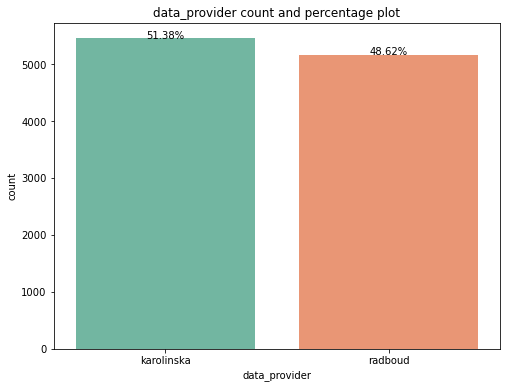

In [5]:
data_analysis.plot_count(df=train, feature='data_provider', title = 'data_provider count and percentage plot')

In [6]:
temp = train.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =temp.isup_grade,
    values = temp.image_id,
    title = {"position": "top center", "text": "Funnel-Chart of ISUP_grade Distribution"}
    ))
fig.show()


In [7]:

temp.style.background_gradient(cmap='Purples')


c:\Users\user\.julia\conda\3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



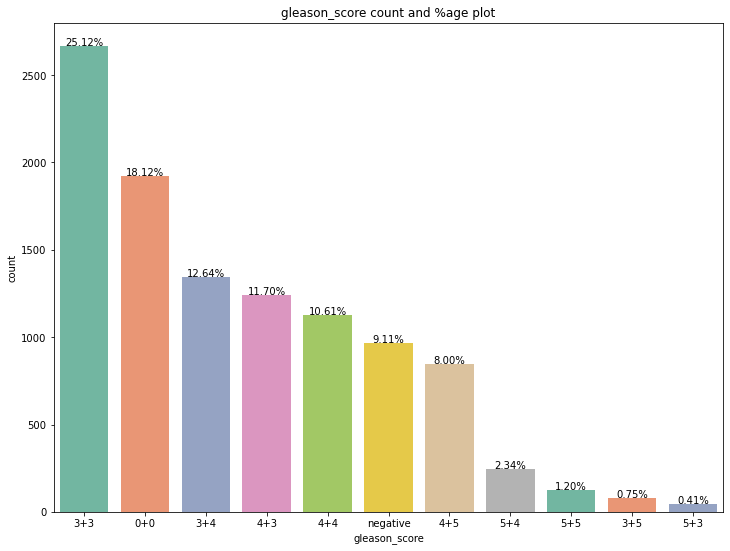

In [8]:
data_analysis.plot_count(df=train, feature='gleason_score', title = 'gleason_score count and %age plot', size=3)

In [9]:
temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Reds')

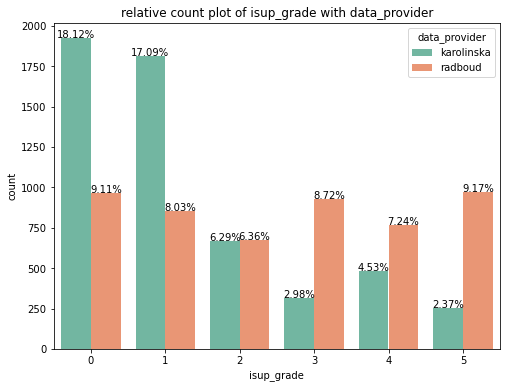

In [10]:
data_analysis.plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider', title = 'relative count plot of isup_grade with data_provider', size=2)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


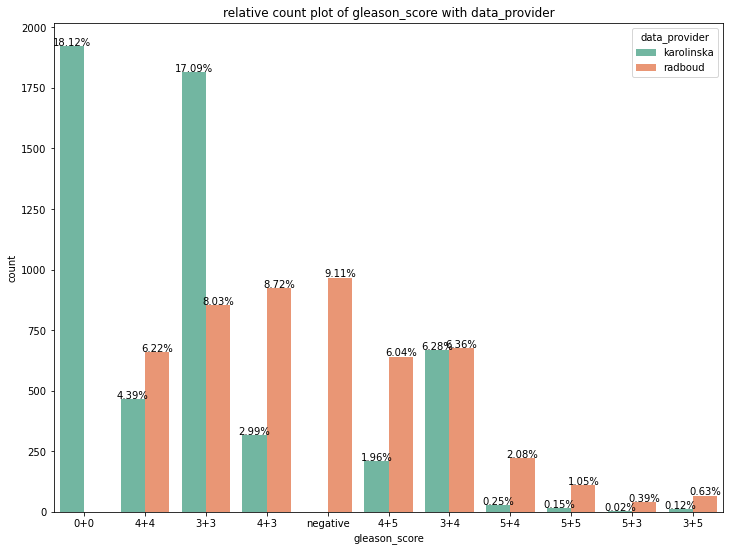

In [11]:
data_analysis.plot_relative_distribution(df=train, feature='gleason_score', hue='data_provider', title = 'relative count plot of gleason_score with data_provider', size=3)

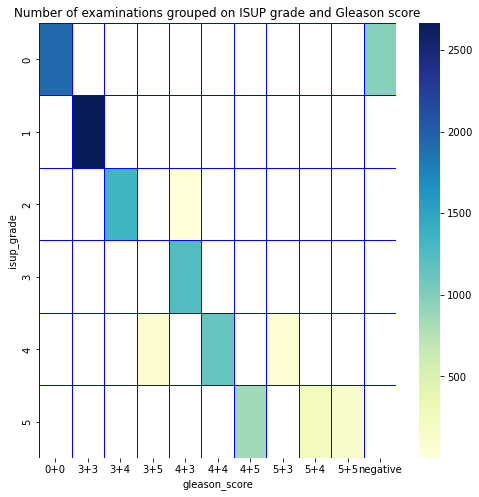

In [12]:
tmp = train.groupby('isup_grade')['gleason_score'].value_counts()
df = pd.DataFrame(data={'values': tmp.values}, index=tmp.index).reset_index()

fig, ax = plt.subplots(nrows=1,figsize=(8,8))
heatmap_data = pd.pivot_table(df, values='values', index=['isup_grade'], columns='gleason_score')
sns.heatmap(heatmap_data, cmap="YlGnBu",linewidth=0.5, linecolor='blue')
plt.title('Number of examinations grouped on ISUP grade and Gleason score')
plt.show()

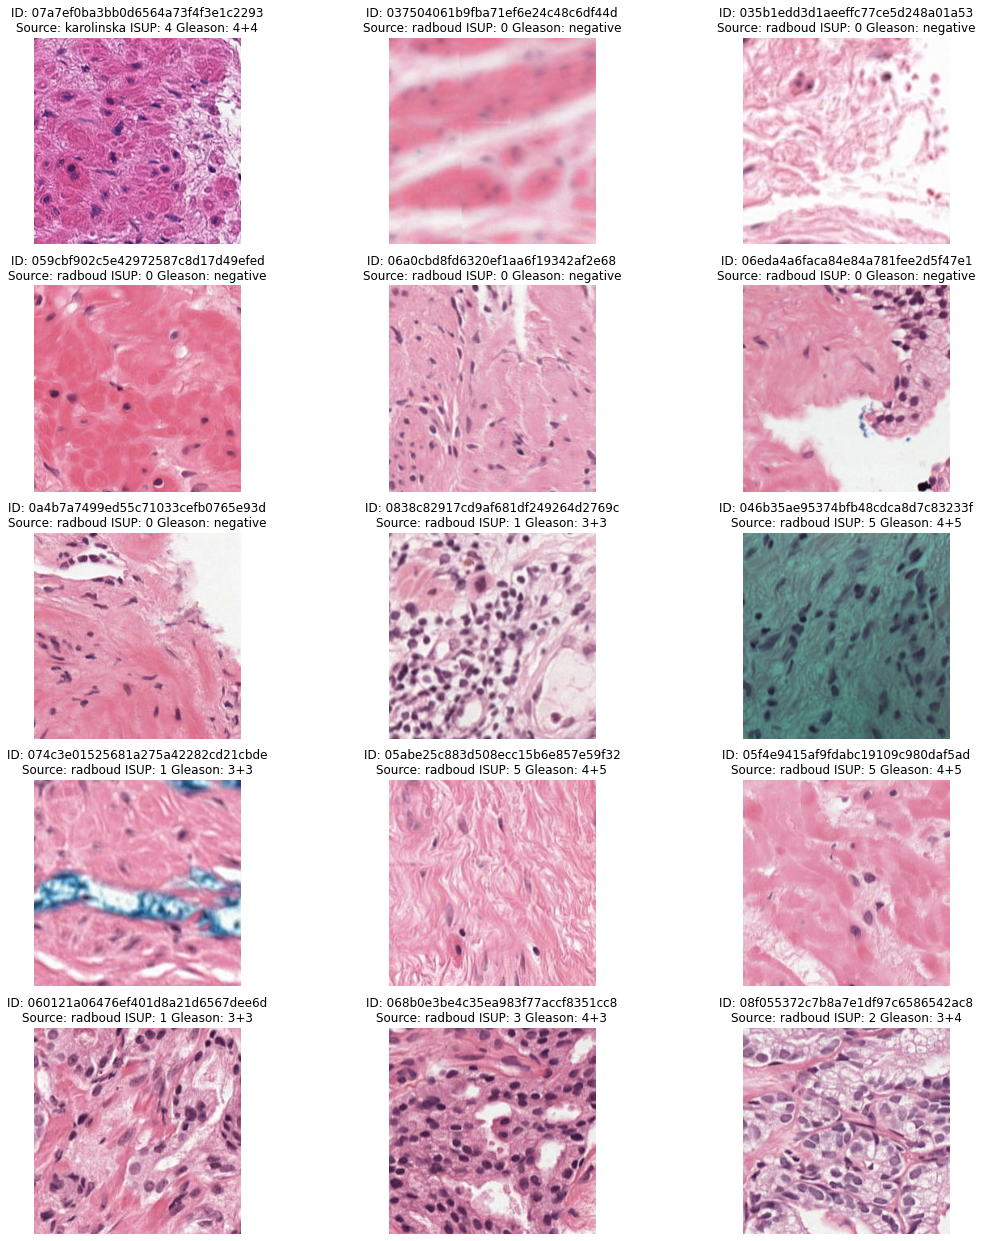

In [13]:

#images = random.sample(list(train.index.values),15)

images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]
train=train.set_index('image_id')
data_analysis.display_images(images,train)

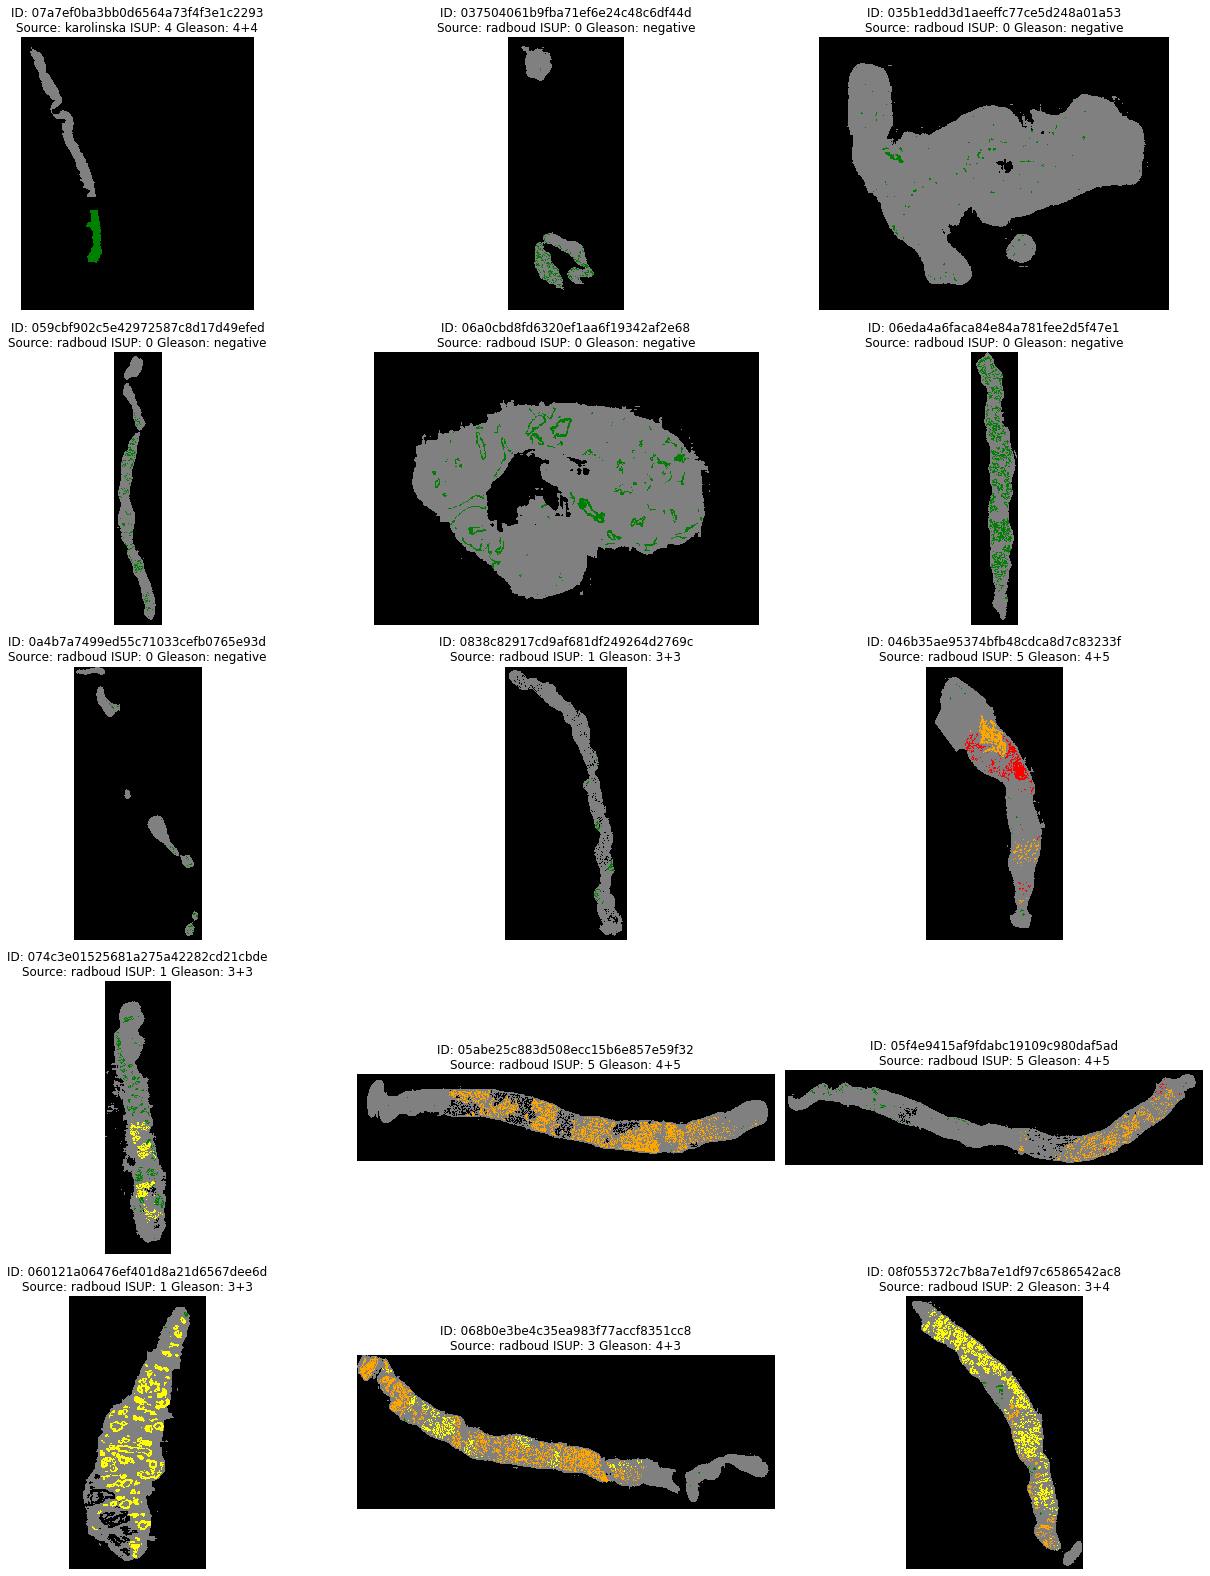

In [14]:
data_analysis.display_masks(images,train)



In [15]:
data_providers = ['karolinska', 'radboud']
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
masks = os.listdir(mask_dir)
masks_df = pd.Series(masks).to_frame()
masks_df.columns = ['mask_file_name']
masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
del masks_df
print(f"There are {len(train_df[train_df.mask_file_name.isna()])} images without a mask.")

## removing items where image mask is null
train_df = train_df[~train_df.mask_file_name.isna()]

There are 100 images without a mask.


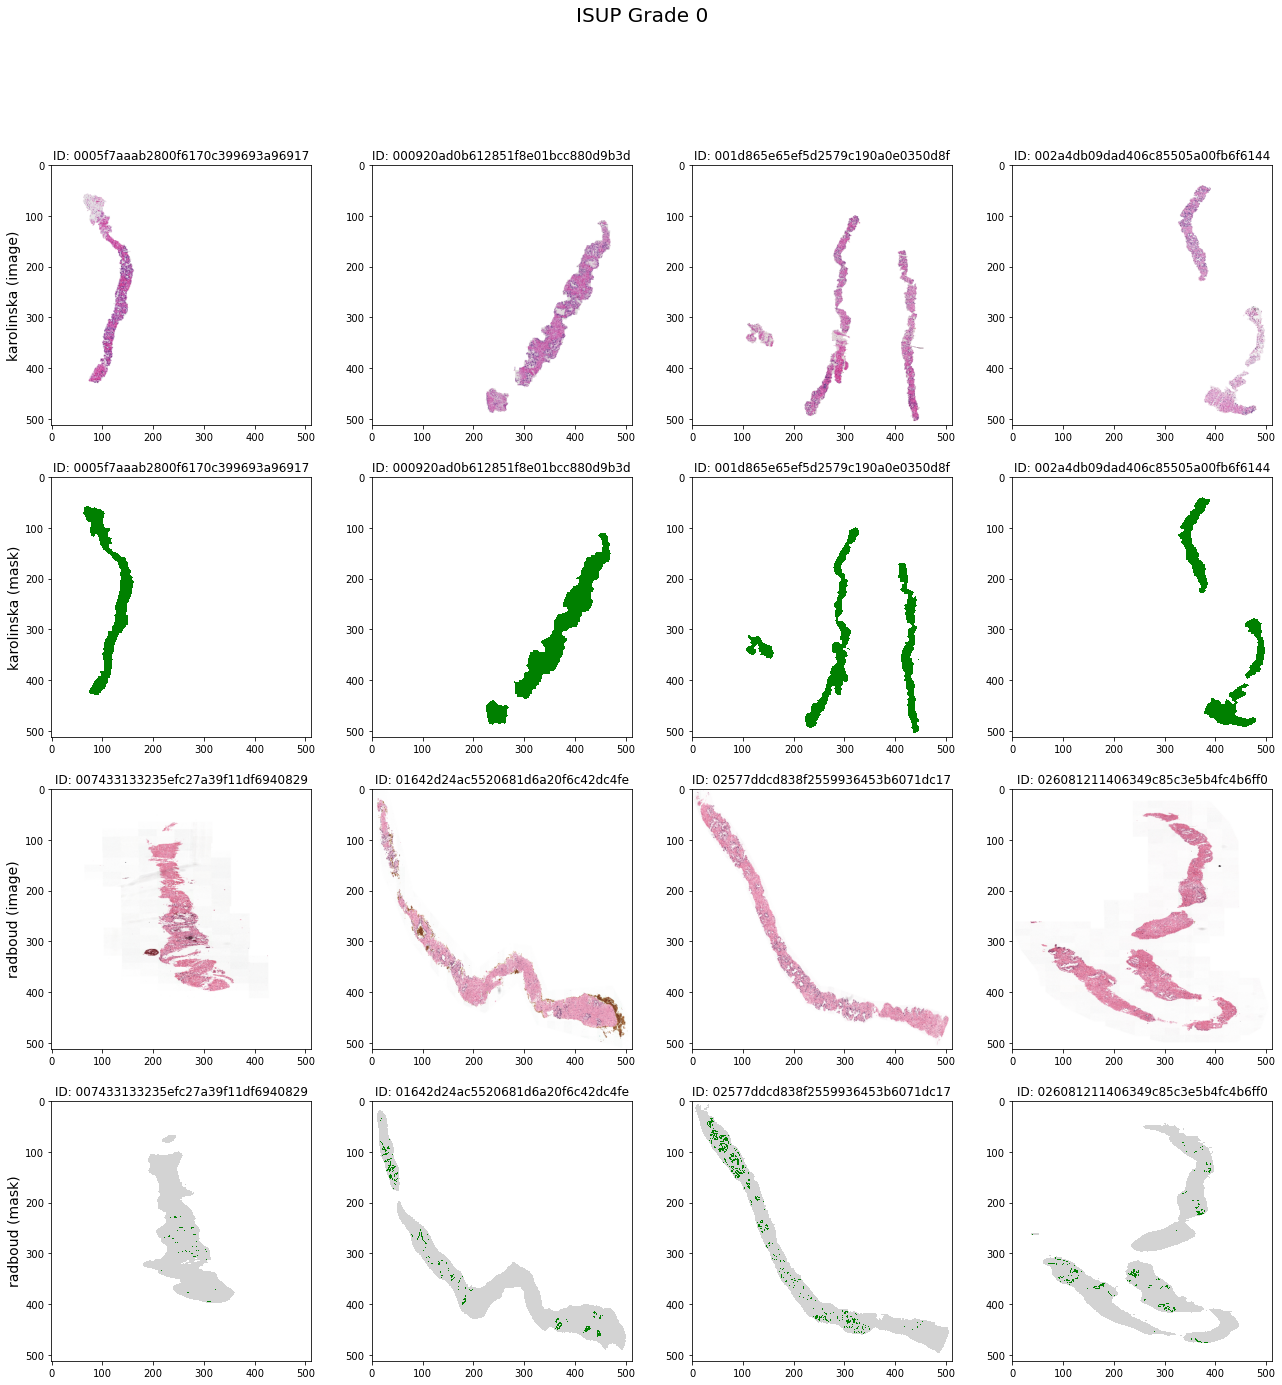

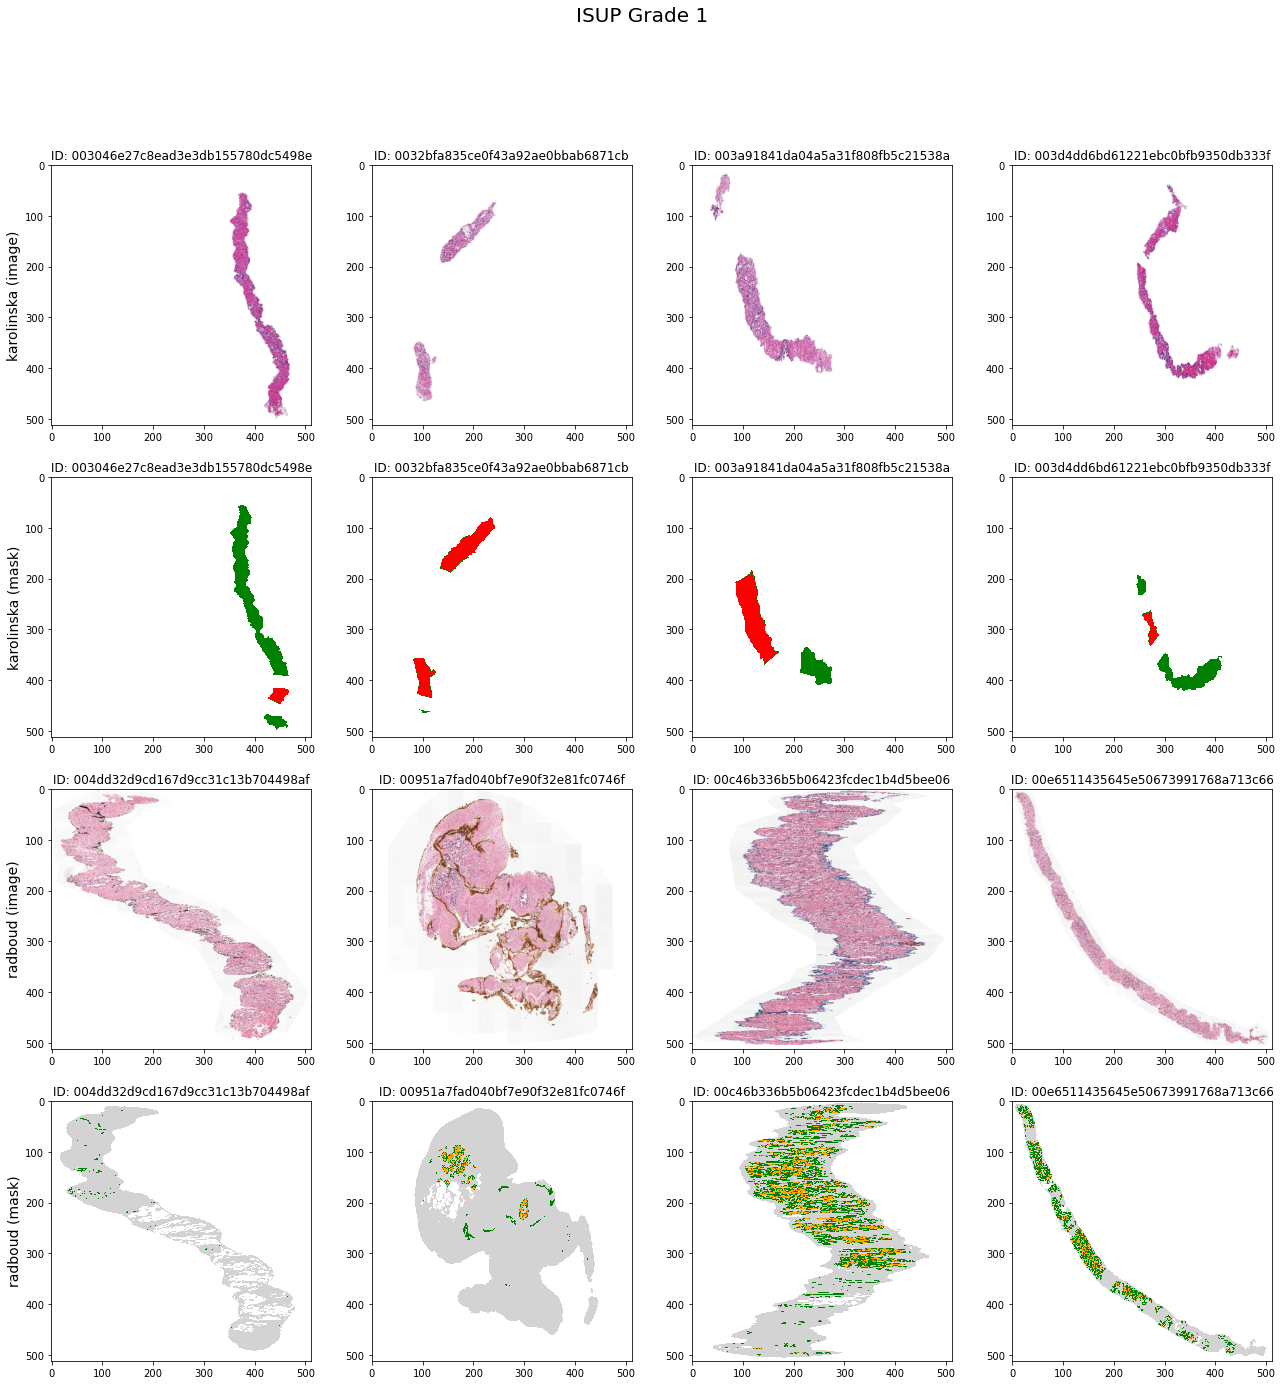

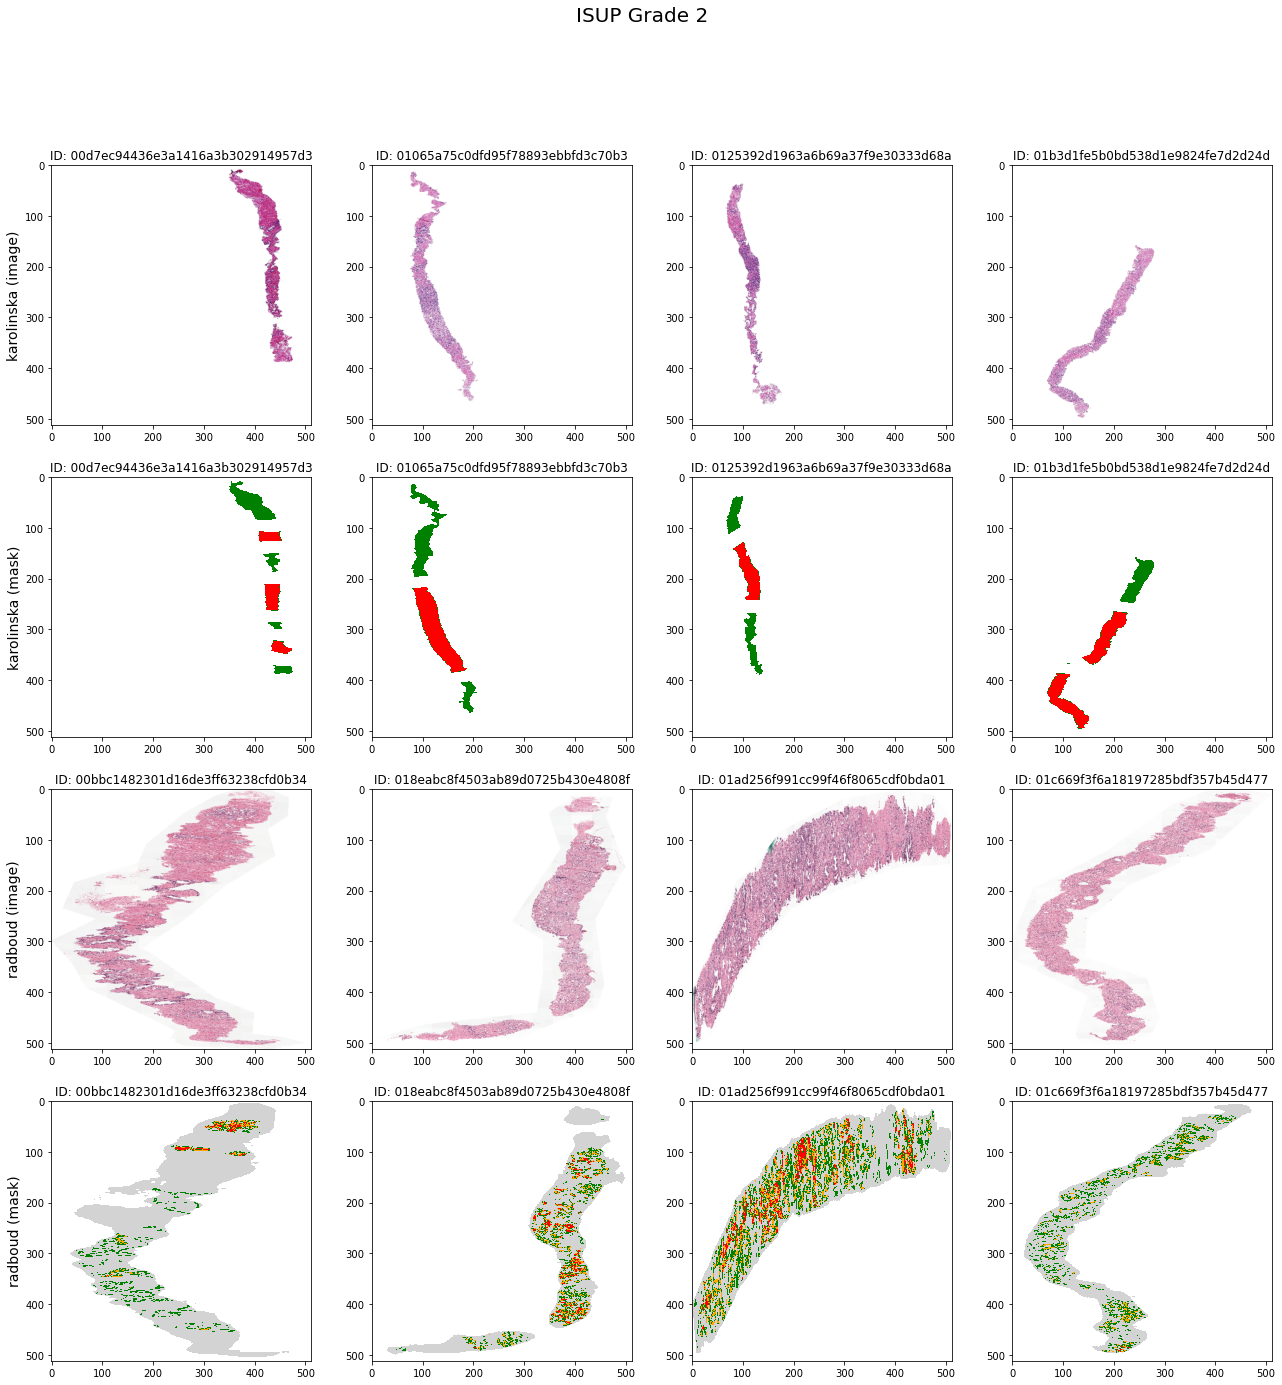

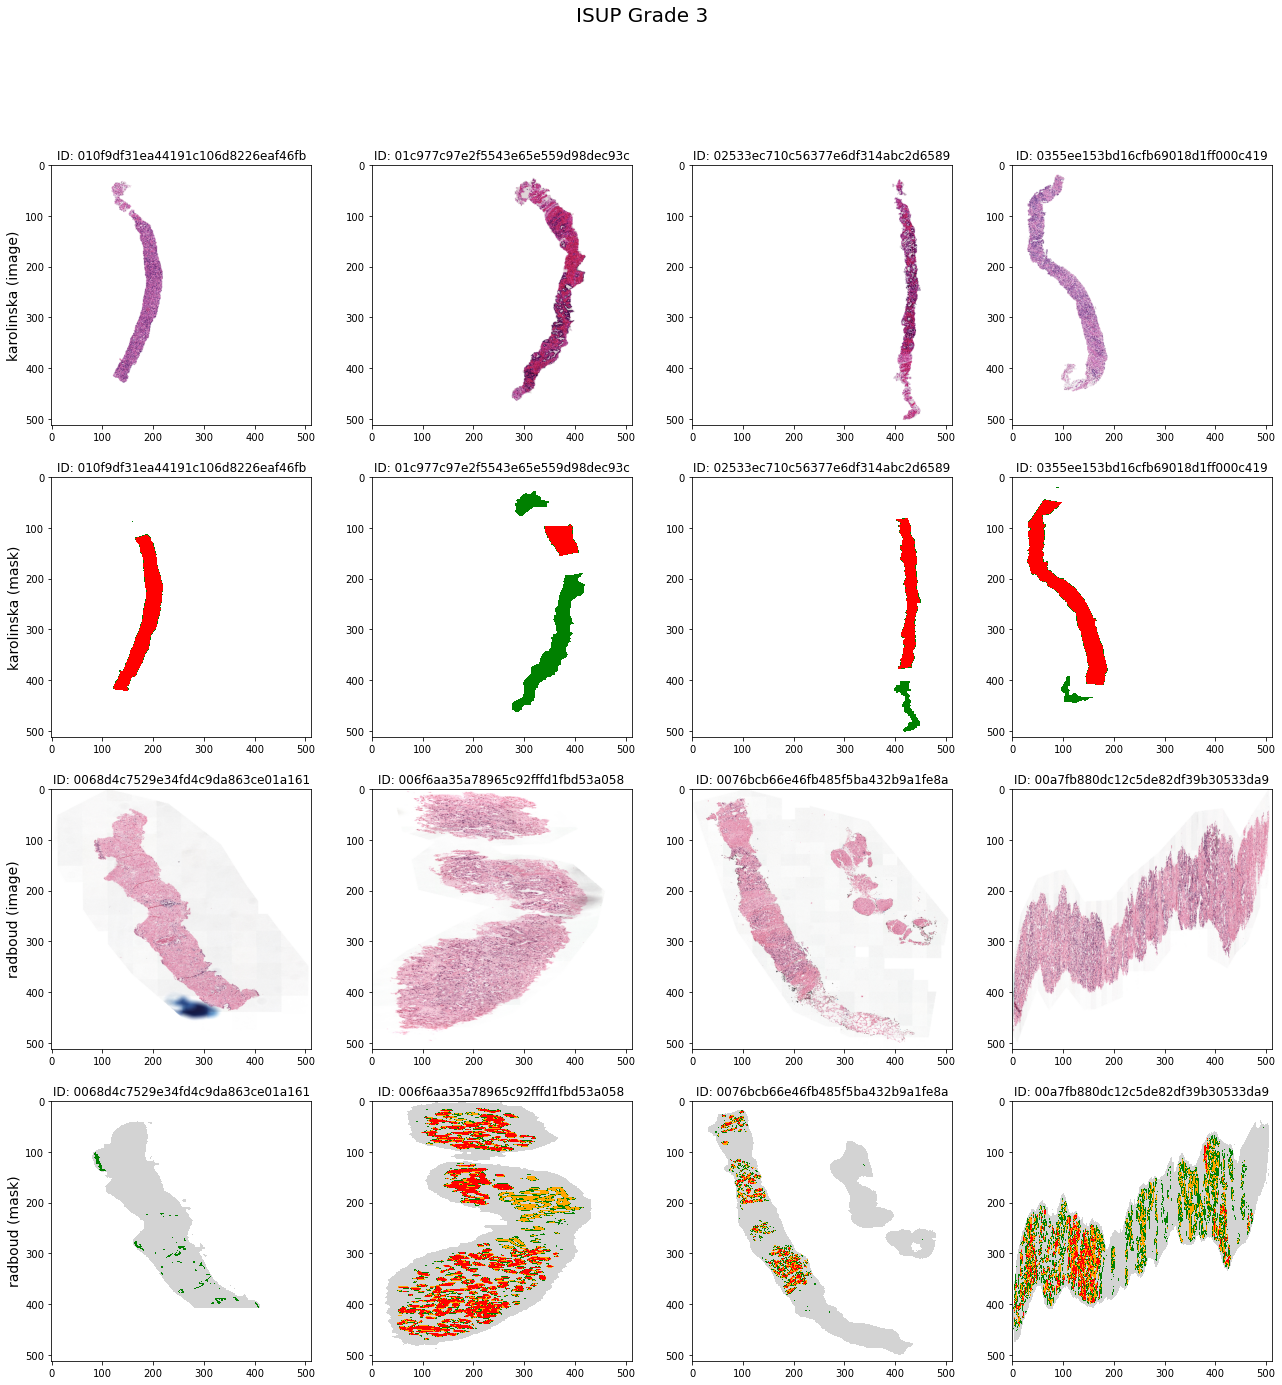

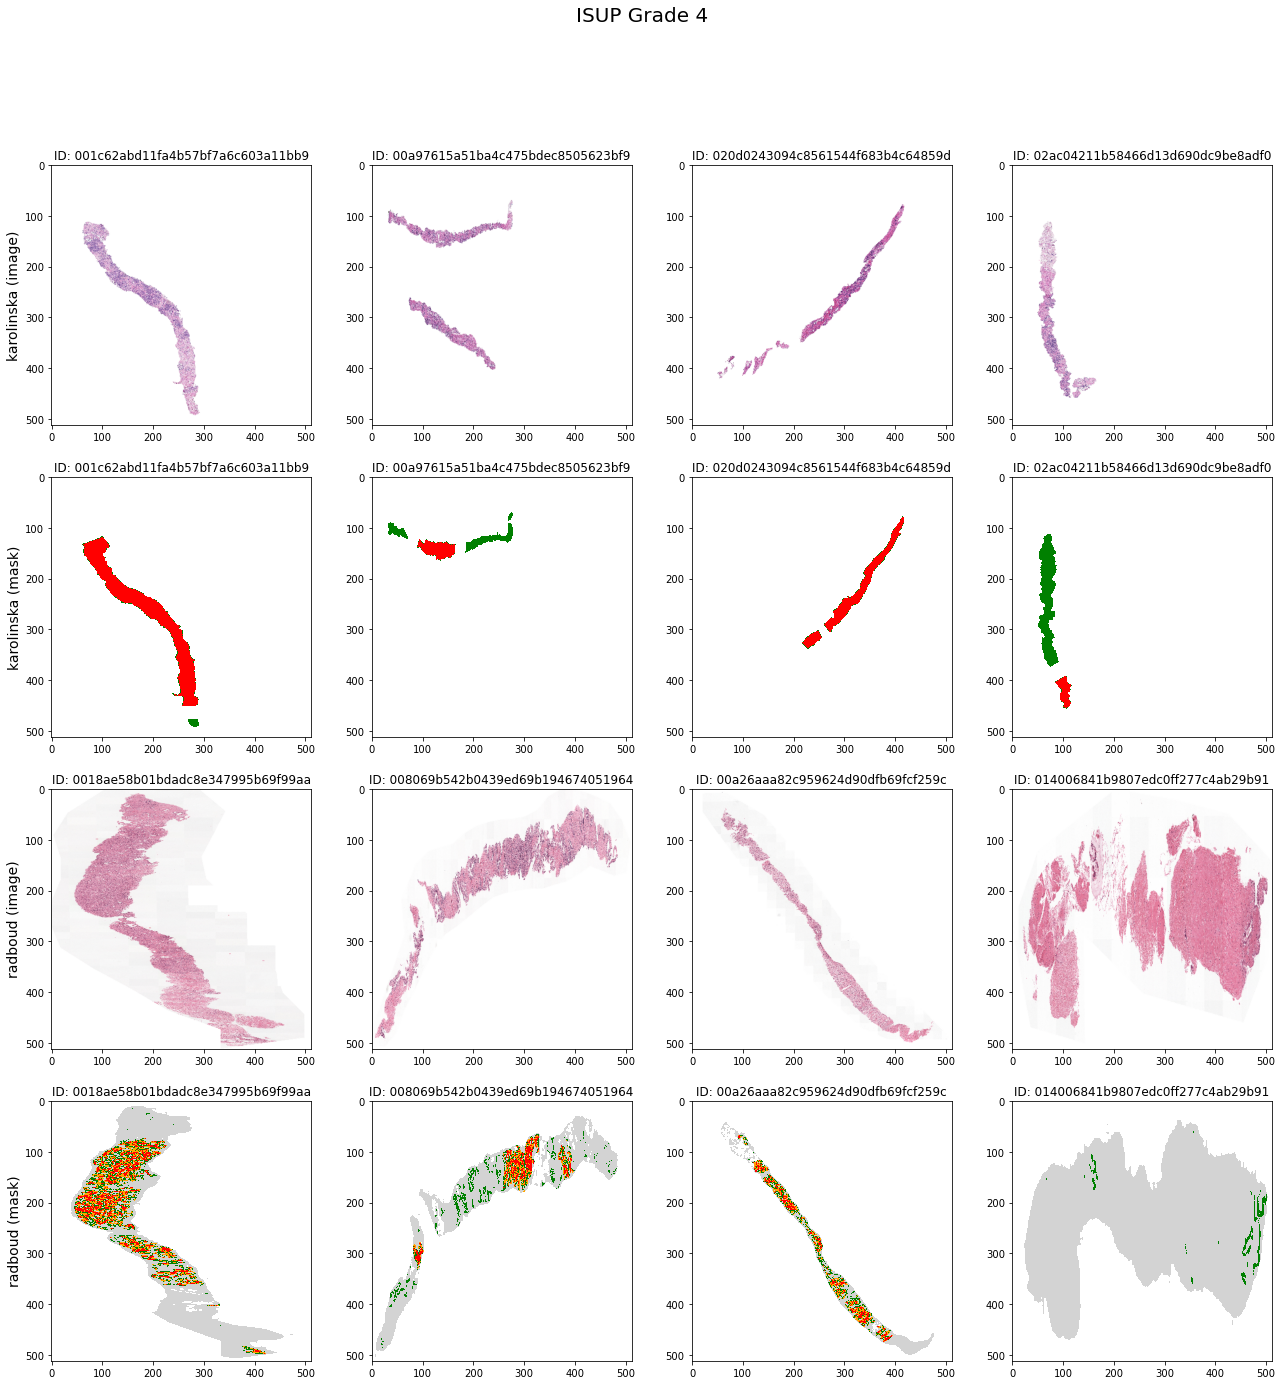

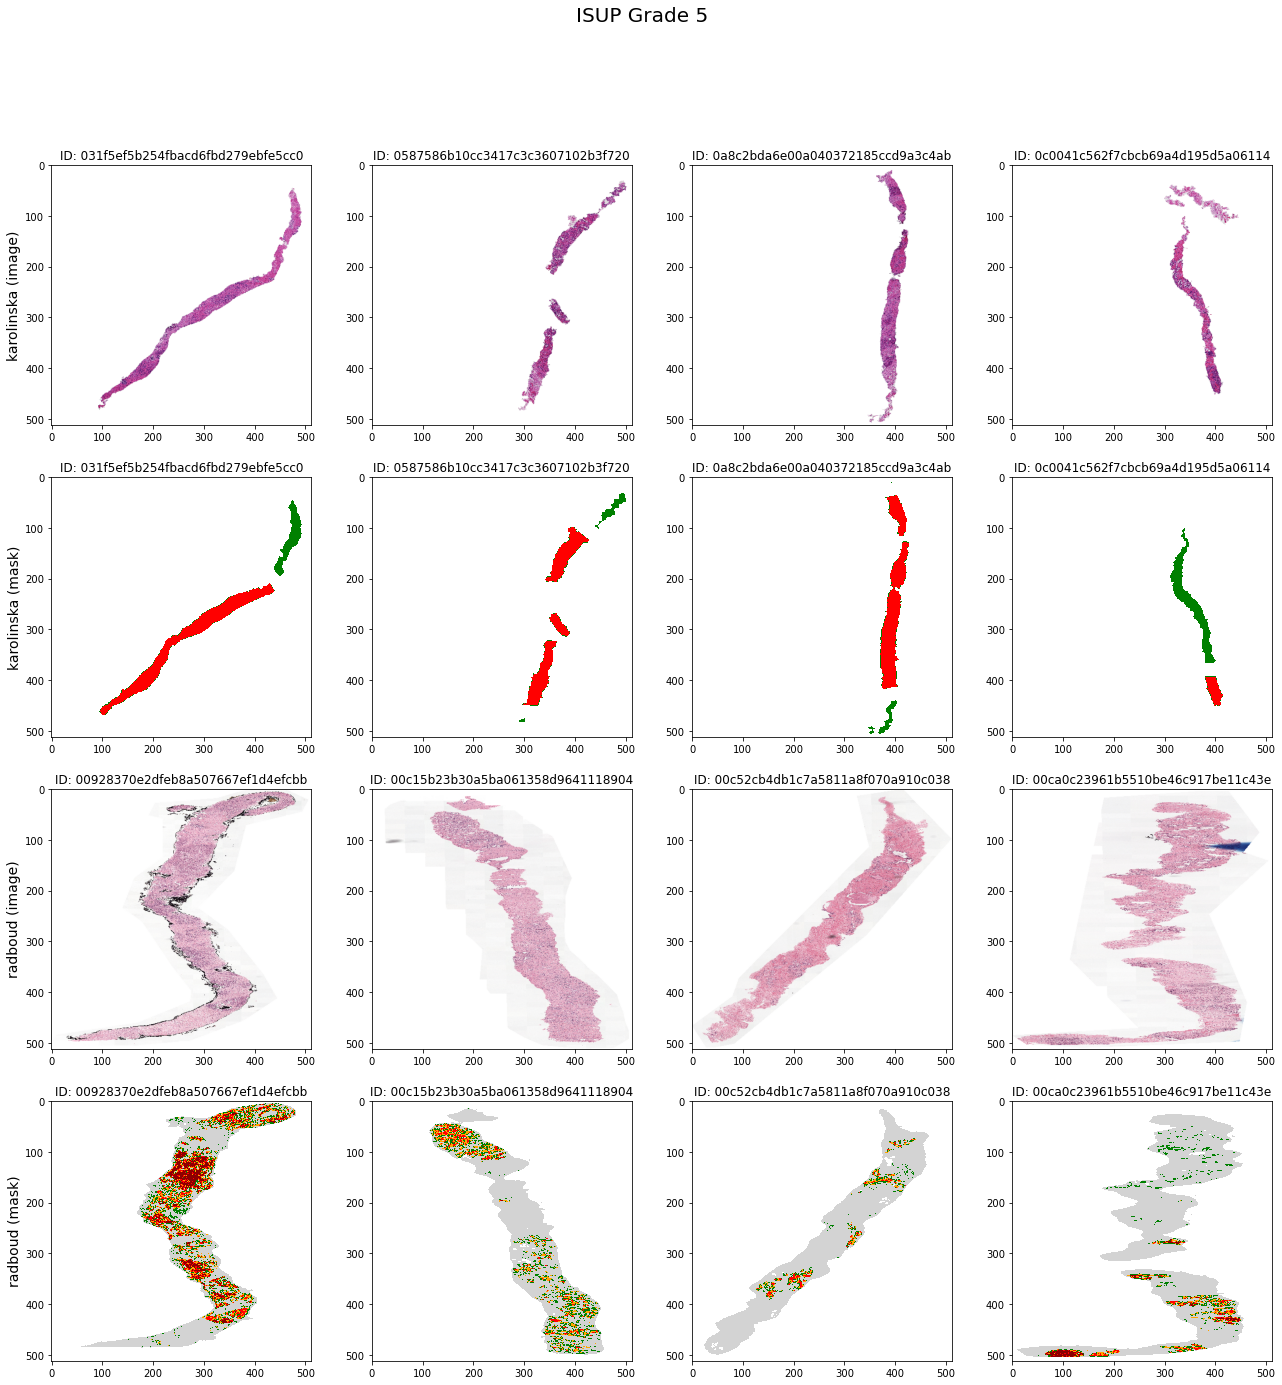

In [16]:
labels = []
for grade in range(train.isup_grade.nunique()):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22, 22))

    for i, row in enumerate(ax):
        idx = i//2
        temp = train_df[(train_df.isup_grade == grade) & (train_df.data_provider == data_providers[idx])].image_id.head(4).reset_index(drop=True)
        if i%2 < 1:
            labels.append(f'{data_providers[idx]} (image)')
            for j, col in enumerate(row):
                col.imshow(data_analysis.load_and_resize_image(temp[j]))
                col.set_title(f"ID: {temp[j]}")
                
        else:
            labels.append(f'{data_providers[idx]} (mask)')
            for j, col in enumerate(row):
                if data_providers[idx] == 'radboud':
                    col.imshow(data_analysis.load_and_resize_mask(temp[j]), 
                               cmap = matplotlib.colors.ListedColormap(['white', 'lightgrey', 'green', 'orange', 'red', 'darkred']), 
                               norm = matplotlib.colors.Normalize(vmin=0, vmax=5, clip=True))
                else:
                    col.imshow(data_analysis.load_and_resize_mask(temp[j]), 
                           cmap = matplotlib.colors.ListedColormap(['white', 'green', 'red']), 
                           norm = matplotlib.colors.Normalize(vmin=0, vmax=2, clip=True))
                    
                gleason_score = train.loc[temp[j], 'gleason_score']
                col.set_title(f"ID: {temp[j]}")
        
    for row, r in zip(ax[:,0], labels):
        row.set_ylabel(r, rotation=90,  fontsize=14)

    plt.suptitle(f'ISUP Grade {grade}', fontsize=20)
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

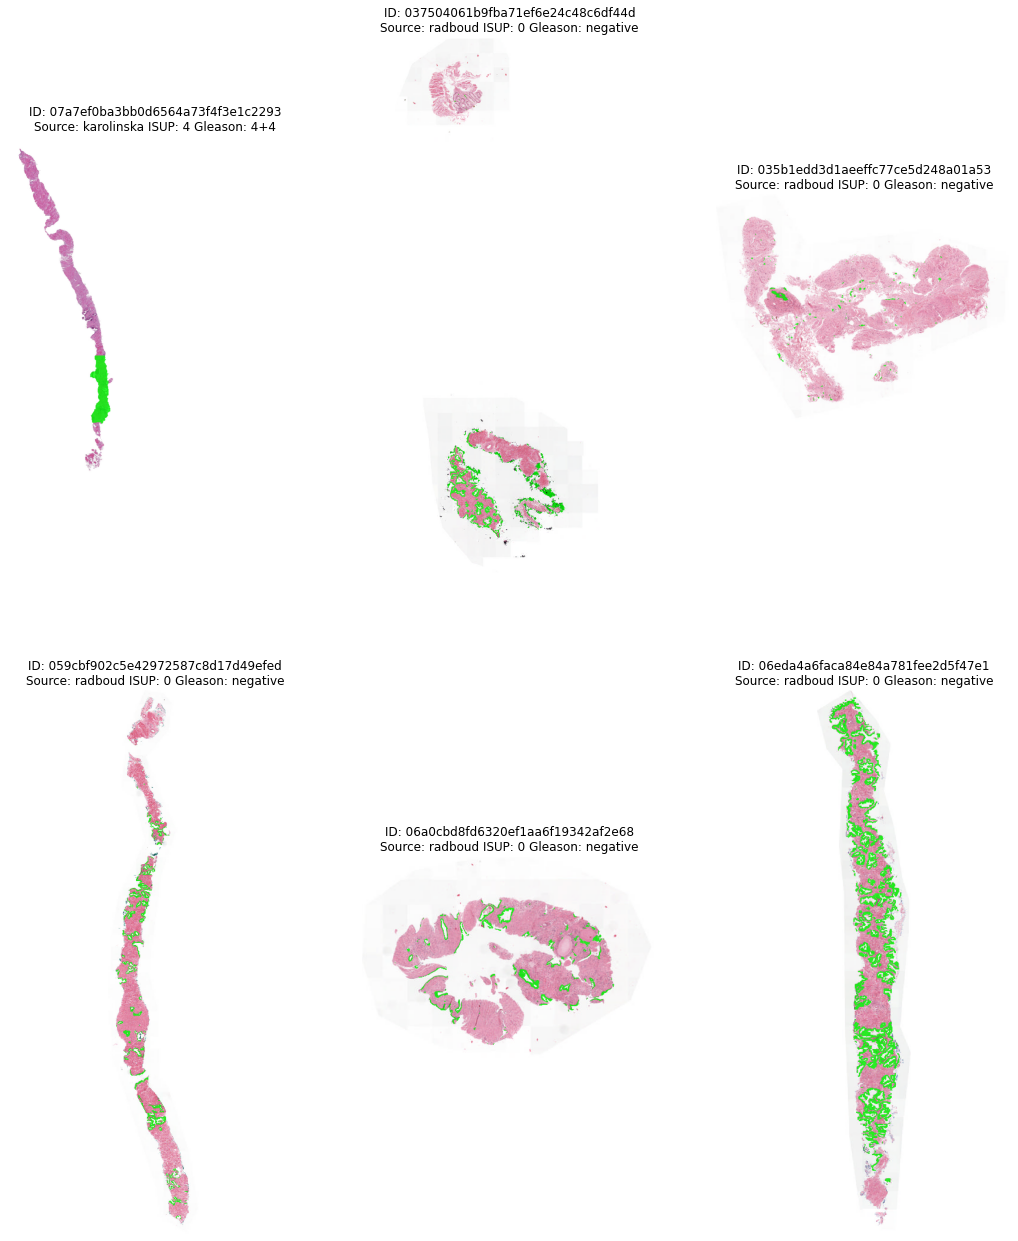

In [17]:
data_analysis.overlay_mask_on_slide(images,train)

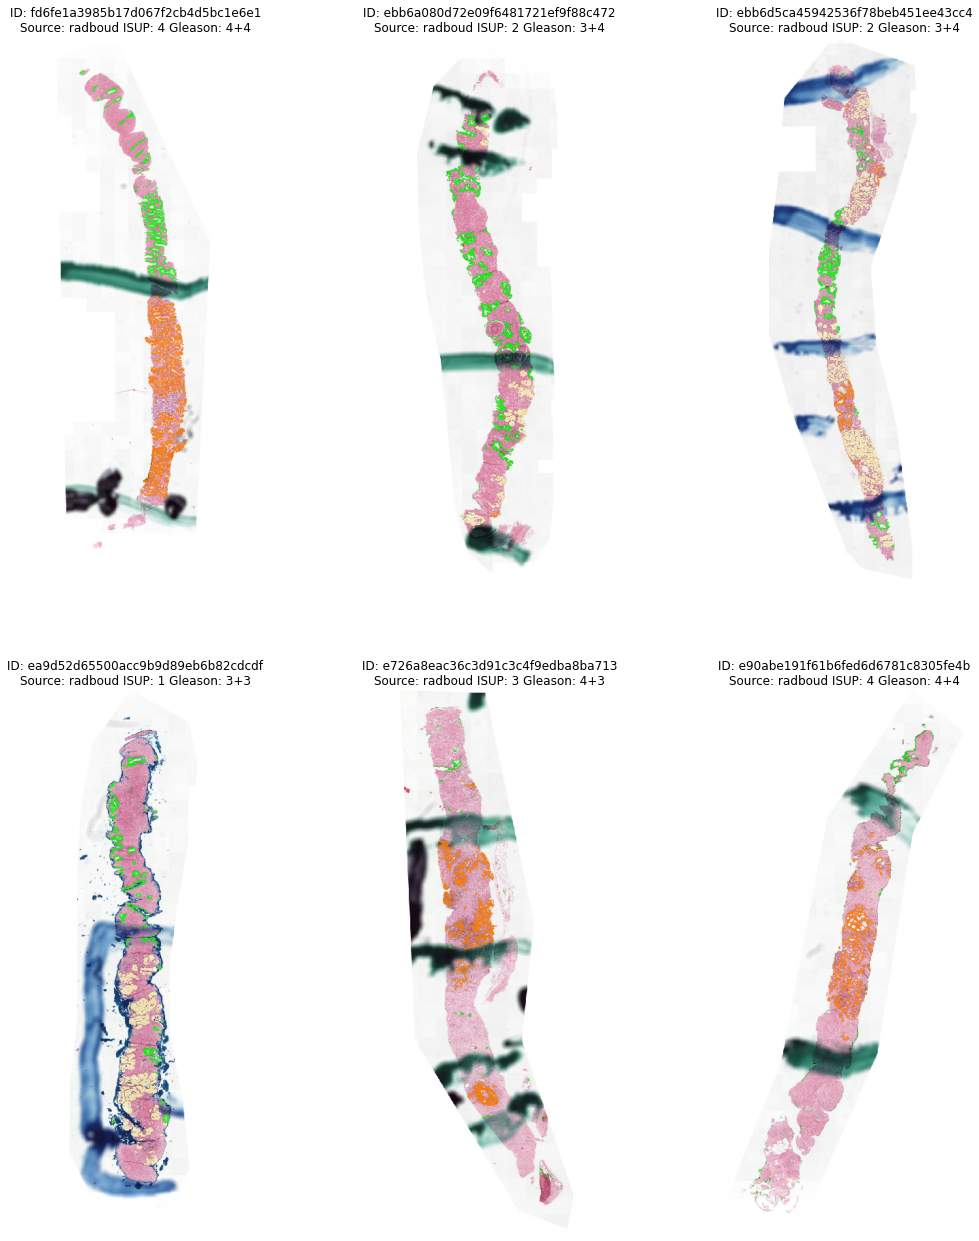

In [18]:
pen_marked_images = [
    'fd6fe1a3985b17d067f2cb4d5bc1e6e1',
    'ebb6a080d72e09f6481721ef9f88c472',
    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',
    'e726a8eac36c3d91c3c4f9edba8ba713',
    'e90abe191f61b6fed6d6781c8305fe4b',
    # 'fd0bb45eba479a7f7d953f41d574bf9f',
    # 'ff10f937c3d52eff6ad4dd733f2bc3ac',
    # 'feee2e895355a921f2b75b54debad328',
    # 'feac91652a1c5accff08217d19116f1c',
    # 'fb01a0a69517bb47d7f4699b6217f69d',
    # 'f00ec753b5618cfb30519db0947fe724',
    # 'e9a4f528b33479412ee019e155e1a197',
    # 'f062f6c1128e0e9d51a76747d9018849',
    # 'f39bf22d9a2f313425ee201932bac91a',
]

data_analysis.overlay_mask_on_slide(pen_marked_images,train)

In [19]:
dims, spacings, level_counts = [], [], []
down_levels, level_dims = [], []

# train = train.sample(300)
for i in train.index.values.tolist():
    slide = openslide.OpenSlide(BASE_PATH+"/train_images/"+i+".tiff")
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    dims.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    down_levels.append(slide.level_downsamples)
    level_dims.append(slide.level_dimensions)
    slide.close()
    del slide

train['width']  = [i[0] for i in dims]
train['height'] = [i[1] for i in dims]
train['spacing'] = spacings
train['level_count'] = level_counts

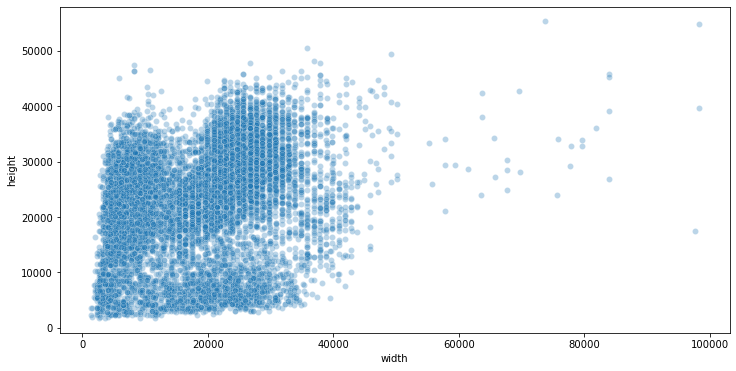

In [20]:


fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='width', y='height', data=train, alpha=0.3)
#plt.title("height(y) width(x) scatter plot")
plt.show()



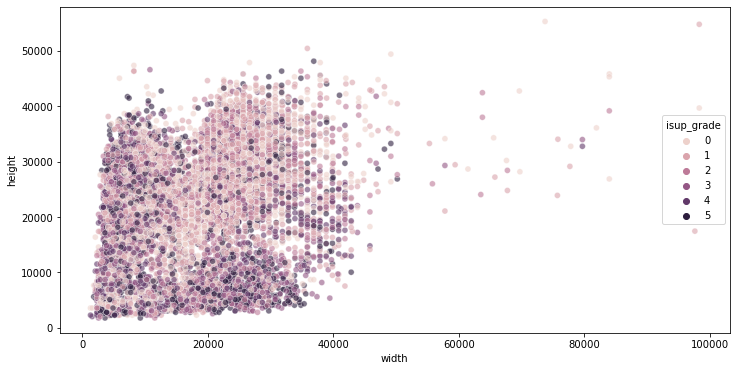

In [21]:


fig = plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x='width', y='height', hue='isup_grade', data=train, alpha=0.6)
#plt.title("height(y) width(x) scatter plot with target")
plt.show()



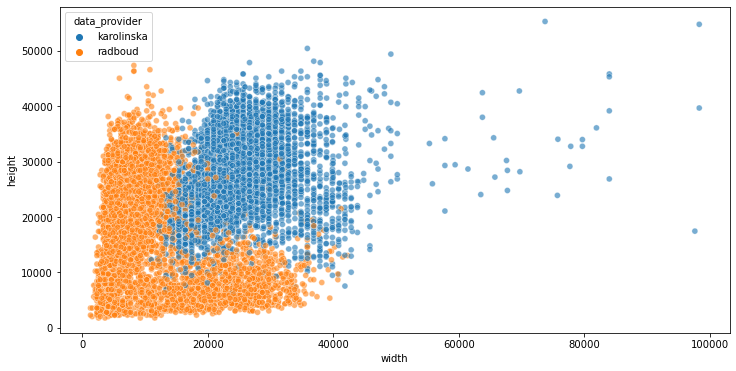

In [22]:
fig = plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x='width', y='height', hue='data_provider', data=train, alpha=0.6)
#plt.title("height(y) width(x) scatter plot with target")
plt.show()

c:\Users\user\.julia\conda\3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\user\.julia\conda\3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



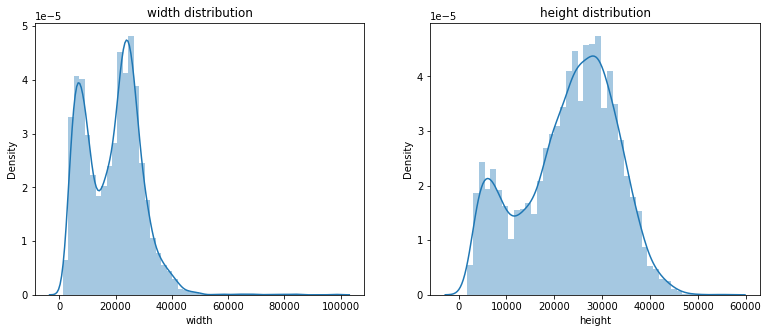

In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.distplot(ax=ax1, a=train['width'])
ax1.set_title("width distribution")
sns.distplot(ax=ax2, a=train['height'])
ax2.set_title("height distribution")
plt.show()



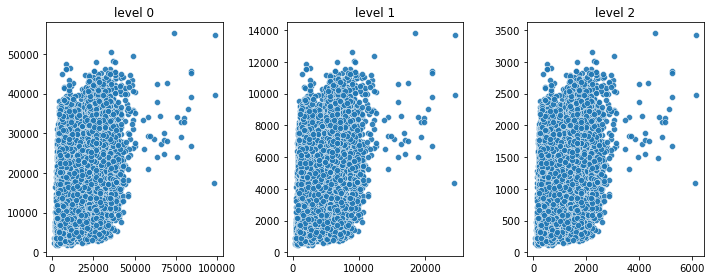

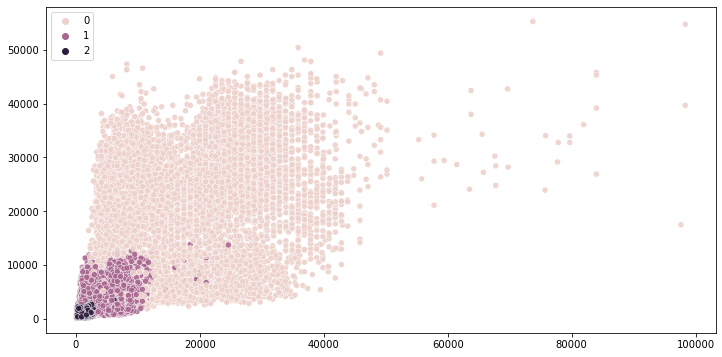

In [ ]:
shapes = [j for i in level_dims for j in i]
level  = np.array([j for i in level_dims for j in range(len(i))])
widths  = np.array([i[0] for i in shapes])
heights = np.array([i[1] for i in shapes])
fig, axes = plt.subplots(1, 3 ,figsize=(10,4))
for i in range(3):
    ax = sns.scatterplot(ax=axes[i], x=widths[level==i], y=heights[level==i], alpha=0.9)
    axes[i].set_title(f"level {i}")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,6))
sns.scatterplot(x=widths, y=heights,hue=level, alpha=0.9)
plt.show()

In [ ]:


print(f"unique level counts : {train['level_count'].unique()}")
print(f"unique spacings     : {train['spacing'].unique()}")
print(f"unique down levels  : {pd.Series([round(j) for i in down_levels for j in i]).unique()}")



unique level counts : [3]
unique spacings     : [0.45201826 0.48618764 0.50319824]
unique down levels  : [ 1  4 16]


In [ ]:


train.groupby('isup_grade').gleason_score.unique().to_frame().style.set_caption('Mapping of ISUP Grade to Gleason Score')



In [ ]:


train[(train.isup_grade == 2) & (train.gleason_score != '3+4')]



data_provider  isup_grade gleason_score  \
image_id                                                                   
b0a92a74cb53899311acc30b7405e101    karolinska           2           4+3   

                                  width  height   spacing  level_count  
image_id                                                                
b0a92a74cb53899311acc30b7405e101  20916   35512  0.503198            3